# Import Module

In [7]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist

# Load Data

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# scale dataset to [-1, +1]
X_train, X_test = X_train / 255.0 * 2 - 1, X_test / 255.0 * 2 - 1
print(X_train.shape, X_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


In [9]:
N, H, W = X_train.shape
D = H * W

latent_dim = 100    # D for latent space, hyperparam

# flatten dataset
X_train = X_train.reshape(-1, D)
X_test = X_test.reshape(-1, D)

# Modeling

In [10]:
# recognize fake images
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

# generate fake images
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)

    model = Model(i, x)
    return model

# save random samples from the generator
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)    
    imgs = 0.5 * imgs + 0.5     # Rescale images 0 - 1

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [11]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])
discriminator.trainable = False     # only generator is trained

generator = build_generator(latent_dim)

z = Input(shape=(latent_dim,))
img = generator(z)      # Pass noise into image generator

fake_pred = discriminator(img)

combined_model = Model(z, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
combined_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Functional)         (None, 784)               1493520   
_________________________________________________________________
model (Functional)           (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [12]:
!mkdir gan_images

In [13]:
%%time
batch_size = 32
epochs = 30000
sample_period = 200 # checkpoint

y_true = np.ones(batch_size)
y_false = np.zeros(batch_size)

d_losses = []
g_losses = []


for epoch in range(epochs):

    ###########################
    ### Train discriminator ###
    ###########################
    
    # Select a random batch
    idx = np.random.randint(0, N, batch_size)
    real_imgs = X_train[idx]
    
    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    # Train the discriminator
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, y_true)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, y_false)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)
    
    
    #######################
    ### Train generator ###
    #######################
    
    for i in range(2):
        noise = np.random.randn(batch_size, latent_dim)
        g_loss = combined_model.train_on_batch(noise, y_true)   # trick discriminator to think image from generator is real
    
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    
    if epoch % sample_period == 0:
        sample_images(epoch)

epoch: 1/30000, d_loss: 0.68, d_acc: 0.53, g_loss: 0.84
epoch: 101/30000, d_loss: 0.03, d_acc: 1.00, g_loss: 3.82
epoch: 201/30000, d_loss: 0.79, d_acc: 0.50, g_loss: 0.97
epoch: 301/30000, d_loss: 0.68, d_acc: 0.48, g_loss: 0.60
epoch: 401/30000, d_loss: 0.68, d_acc: 0.45, g_loss: 0.64
epoch: 501/30000, d_loss: 0.70, d_acc: 0.48, g_loss: 0.64
epoch: 601/30000, d_loss: 0.68, d_acc: 0.52, g_loss: 0.68
epoch: 701/30000, d_loss: 0.69, d_acc: 0.48, g_loss: 0.68
epoch: 801/30000, d_loss: 0.65, d_acc: 0.53, g_loss: 0.70
epoch: 901/30000, d_loss: 0.66, d_acc: 0.58, g_loss: 0.72
epoch: 1001/30000, d_loss: 0.67, d_acc: 0.58, g_loss: 0.79
epoch: 1101/30000, d_loss: 0.67, d_acc: 0.58, g_loss: 0.73
epoch: 1201/30000, d_loss: 0.65, d_acc: 0.61, g_loss: 0.77
epoch: 1301/30000, d_loss: 0.67, d_acc: 0.59, g_loss: 0.81
epoch: 1401/30000, d_loss: 0.63, d_acc: 0.61, g_loss: 0.77
epoch: 1501/30000, d_loss: 0.64, d_acc: 0.70, g_loss: 0.84
epoch: 1601/30000, d_loss: 0.62, d_acc: 0.69, g_loss: 0.82
epoch: 17

# Evaluation

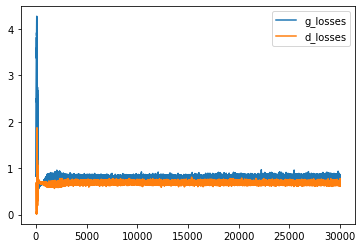

In [14]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

# both losses goes up-and-down because generator learns to c more realistic images every epoch

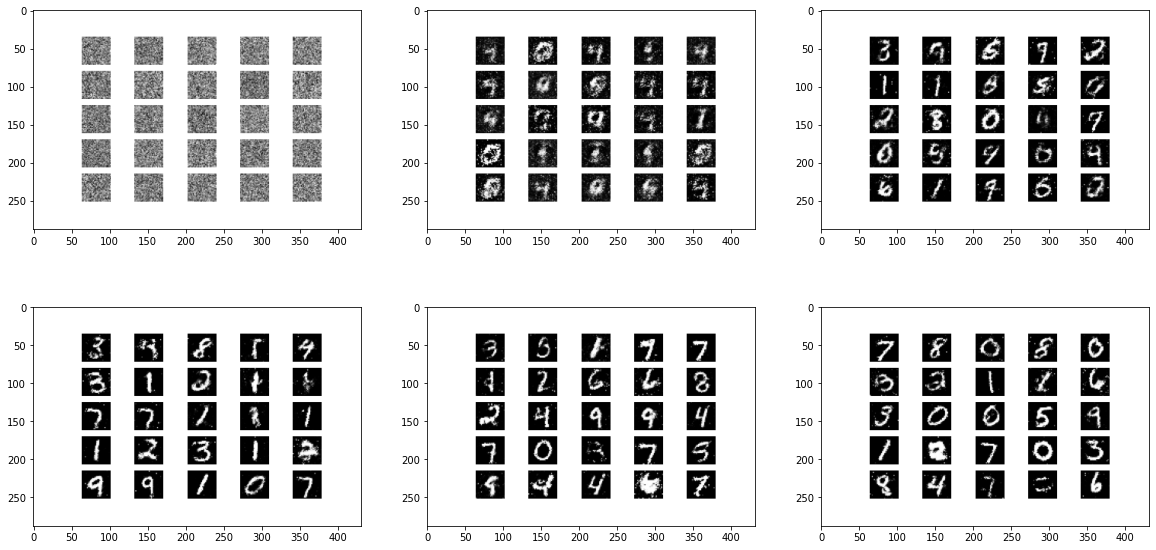

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

axes[0,0].imshow(mpimg.imread('gan_images/0.png'))
axes[0,1].imshow(mpimg.imread('gan_images/1000.png'))
axes[0,2].imshow(mpimg.imread('gan_images/5000.png'))
axes[1,0].imshow(mpimg.imread('gan_images/10000.png'))
axes[1,1].imshow(mpimg.imread('gan_images/20000.png'))
axes[1,2].imshow(mpimg.imread('gan_images/29000.png'))

plt.show();

# generator learned to create mnist-alike images